# Geneva House Renting Consultancy
Capstone Project, Applied Data Science Capstone by IBM/Coursera, Simone Lisi.

## Scaraping immoscout24.ch

This notebook allows to check all the currently available leases listed on the immoscout24.ch website.
By default, we will search for locations within a 5km radius aroun Geneva.
For each available property, we will exctract the following keys:

* 'cityName': city were the property is located. 
* 'extraPrice': price of some utilities, e.g. heating.
* 'price': the total price for the rent, including 'extraPrice'.
* 'latitude': the latitued of the property.
* 'longitude': the longitude of the property.
* 'numberOfRooms': the number of rooms in the property.
* 'street': the address of the property. 
* 'surfaceLiving': the area of the property in sqm.
* 'zip': the postal code associated to the property.
* 'pricePerRoom': price per room, i.e 'price'/'numberOfRooms'.
* 'pricePerSqm': price per sqm, i.e 'price'/'surfaceLiving'.

The results will be stored in a dictionary and saved in the file "db_geneva_app_FA.json", for later use.

Some cells are enclosed markdown cells, starting and ending with: ////////////////////
//////////////////// ////////////////////

These cells are set as markdown, as they are not supposed to be run except when we want to scrape new data, or install missing packages. For this they can be set to 'code'. Otherwise, the program will load data previousely scraped and stored.

We will finally perform an exploratory analysis, find the key feature determining the price of a property and produce insighful boxplots


# /////////////////// //////////////////// ////////////////////
# Installing packages

Set this cell to 'code' if needed.

!conda install -c anaconda bs4 --yes

!conda install -c conda-forge geopy --yes 

!conda install -c conda-forge folium=0.5.0 --yes 

# /////////////////// //////////////////// ////////////////////

In [38]:
## importing libraries
from bs4 import BeautifulSoup
import json
import urllib.request as urllib2
import random
from random import choice
import time
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [8]:
# urlquery from Achim Tack, available on github.
# https://github.com/ATack/GoogleTrafficParser/blob/master/google_traffic_parser.py
def urlquery(url):
    # function cycles randomly through different user agents and time intervals to simulate more natural queries
    try:
        sleeptime = float(random.randint(1,6))/5
        time.sleep(sleeptime)

        agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17',
        'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0',
        'Opera/12.80 (Windows NT 5.1; U; en) Presto/2.10.289 Version/12.02',
        'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)',
        'Mozilla/3.0',
        'Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420+ (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3',
        'Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522+ (KHTML, like Gecko) Safari/419.3',
        'Opera/9.00 (Windows NT 5.1; U; en)']

        agent = choice(agents)
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', agent)]

        html = opener.open(url).read()
        time.sleep(sleeptime)
        
        return html

    except Exception as e:
        print('Something went wrong with Crawling:\n%s' % e)

In [9]:
### utility to explore a complex nested dictionary-list
def structure_data(something, lev, keysearch = ''):
    #print(something, 'is a ', type(something))
    
    if(type(something) is dict):
        for key in something.keys():    
            spaces = '    '*lev
            print(spaces, key, 'is a ', type(something[key]))
            structure_data(something[key], lev+1, keysearch)
                
    elif(type(something) is list):
        for i, element in enumerate(something):
            spaces = '    '*lev
            print(spaces, i, 'is a ', type(element))
            structure_data(element, lev+1, keysearch)
    else:
        spaces = '    '*lev
        print(spaces, something)

In [10]:
## this function converts some troublesome found in the html page to avoid errors while loading 
def get_full_dic(soup):
    for element in soup.prettify().split('\n'):
        if('__INITIAL_STATE__' in element):
            element = element[21:]
            while 'false' in element:
                element = element.replace('false', '0')
            while 'true' in element:
                element = element.replace('true', '1')
            while 'undefined' in element:
                element = element.replace('undefined', '2')
            while 'null' in element:
                element = element.replace('null', '3')
            #print((element))
            dic = json.loads(element)
        
    return(dic)



## //////////////////// ////////////////////  ////////////////////
## The following cells are meant to be used to scrape the website and store the results in a file. 
## They are meant to be used only the first time the code is run, or whnever we want to look for new properties.
## Leave them as markdown otherwise.

### Run this on page  = 1 to find total number of pages
what = 'real-estate'
rent = 'rent'
where = 'city-geneve'
page = 1
radius = 5 #km

url ='https://www.immoscout24.ch/en/%s/%s/%s?pn=%s&r=%s' % (what, rent, where, page, radius)
print(url)

soup = BeautifulSoup(urlquery(url), 'html.parser')
### find number of pages
dic = get_full_dic(soup)
max_pages = dic['pages']['searchResult']['resultData']['pagingData']['totalPages']

max_pages


### scraping all pages on the immoscout24.ch website
i = 0
dic_all = {}
while i < max_pages :
    i +=1
    page = i
    url ='https://www.immoscout24.ch/en/%s/%s/%s?pn=%s&r=%s' % (what, rent, where, page, radius)
    soup = BeautifulSoup(urlquery(url), 'html.parser')
    dicname = 'page' +str(i)
    dic_all[dicname] = get_full_dic(soup)

### data downloaded and saved on the 29/06/2020

with open('GenevaRents_FA.json', 'w') as fp:
    json.dump(dic_all, fp)

## We can resume running the code from the cell below
## //////////////////// //////////////////// ////////////////////


In [11]:
### run this put data into dictionary without querying immoscout24.ch again
dic_all2 = {}
with open('GenevaRents_FA.json', 'r') as json_file: 
    dic_all2 = json.load(json_file) 
max_pages = 37

In [12]:
### get data from an apartment
dic_all2['page1']['pages']['searchResult']['resultData']['listData'][0]

{'id': 6065071,
 'accountId': 24363,
 'agency': {'companyCity': 'Genève',
  'companyName1': 'Livit SA',
  'companyName2': 'Real Estate Management',
  'companyStreet': 'Rue de Jargonnant 1',
  'companyZip': '1207',
  'showLogoOnSerp': 1,
  'logoUrl': 'https://www.immoscout24.ch/resources/memberlogos/L24363-R.jpg',
  'logoUrlDetailPage': 'https://www.immoscout24.ch/resources/memberlogos/L24363-R.jpg',
  'isAccountMigrated': 1},
 'availableFrom': '2020-07-16T00:00:00+02:00',
 'availableFromFormatted': '16.07.2020',
 'cityId': 1286,
 'cityName': 'Genève',
 'commuteTimes': {'defaultPois': [{'label': 'Geneva Cornavin',
    'transportations': [{'transportationTypeId': 6,
      'travelTime': 630,
      'isReachable': 1},
     {'transportationTypeId': 10, 'travelTime': 1162, 'isReachable': 1},
     {'transportationTypeId': 3, 'travelTime': 771, 'isReachable': 1}]}]},
 'countryId': 1,
 'extraPrice': 350,
 'extraPriceFormatted': 'CHF 350.—',
 'geoAccuracy': 8,
 'grossPrice': 2550,
 'grossPriceFor

In [13]:
# selecting relevant keys
rel_keys = ['cityName', 'extraPrice', 'price', 
            'latitude', 'longitude', 'numberOfRooms', 'street',
           'surfaceLiving', 'zip']


In [14]:
### Create a dictionary with a key for each id
i = 0
app_dic4db = {}
while i < max_pages :
    i += 1
    page_n = 'page' + str(i)
    for element in dic_all2[page_n]['pages']['searchResult']['resultData']['listData']:
        app_id = element['id']
        app_dic4db[app_id] = []
        
        for key in rel_keys :
            if key in element.keys():
                app_dic4db[app_id].append(element[key])
            else:
                app_dic4db[app_id].append(None)

In [15]:
## we store the results in a database
df  = pd.DataFrame(app_dic4db, index = rel_keys)
df = df.transpose()

In [16]:
df.head(10)

,cityName,extraPrice,price,latitude,longitude,numberOfRooms,street,surfaceLiving,zip
6065071,Genève,350,2550,46.1936,6.16698,4,Rue Le Corbusier 18,85,1208
6069271,Genève,None,2350,46.1994,6.13369,3,"Boulevard Carl-VOGT 35, Geneva, Geneva",None,1205
6046525,Genève,200,4200,46.1965,6.1609,5.5,Route de Malagnou 40E,110,1208
6063101,Genève,170,2810,46.2043,6.15891,4,Rue du 31-Décembre 16,60,1207
6054808,Genève,250,4750,46.1952,6.15391,7,Rue Marignac,165,1206
6037279,Le Lignon,200,2700,46.2031,6.09613,6,Avenue du Lignon,107,1219
6034462,Genève,None,250,46.2082,6.12309,None,sur demande,None,1203
6034463,Genève,None,250,46.2167,6.13672,None,sur demande,None,1202
6010008,Petit-Lancy,None,700,46.1912,6.11706,1,None,None,1213
6010104,Petit-Lancy,None,700,46.1912,6.11706,1,None,None,1213


### Data sanity check

In [17]:
# we start checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 6065071 to 6078359
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cityName       866 non-null    object
 1   extraPrice     259 non-null    object
 2   price          825 non-null    object
 3   latitude       866 non-null    object
 4   longitude      866 non-null    object
 5   numberOfRooms  752 non-null    object
 6   street         546 non-null    object
 7   surfaceLiving  623 non-null    object
 8   zip            866 non-null    object
dtypes: object(9)
memory usage: 67.7+ KB


In [18]:
# we can see that for each apartment, latitude and logitude are always available. However, some key features,
# i.e.number of rooms, surface living, and price  might be missing.
# We drop entries with mssing values.
# At this point we observe that we would be forced to dropp too many entries to use feature 'extraPrice'.
# We can opt to ingnore this feature.

val = df.iloc[3,6]
indexNames = df[ df['numberOfRooms'].isnull() ].index
df.drop(indexNames , inplace=True)
indexNames = df[ df['surfaceLiving'].isnull() ].index
df.drop(indexNames , inplace=True)
indexNames = df[ df['price'].isnull() ].index
df.drop(indexNames , inplace=True)


In [19]:
# we convert the type of the features, as all of them are objects by default
df['extraPrice'] = df[['extraPrice']].astype(float)
df['price'] = df[['price']].astype(float)
df['latitude'] = df[['latitude']].astype(float)
df['longitude'] = df[['longitude']].astype(float)
df['numberOfRooms'] = df[['numberOfRooms']].astype(float)
df['surfaceLiving'] = df[['surfaceLiving']].astype(float)
df['zip'] = df[['zip']].astype(int)

In [20]:
# We check that all entries in our database have non null keyfeatures and that the type of each features
# is now the desired one.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 6065071 to 5802998
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cityName       536 non-null    object 
 1   extraPrice     211 non-null    float64
 2   price          536 non-null    float64
 3   latitude       536 non-null    float64
 4   longitude      536 non-null    float64
 5   numberOfRooms  536 non-null    float64
 6   street         393 non-null    object 
 7   surfaceLiving  536 non-null    float64
 8   zip            536 non-null    int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 41.9+ KB


In [21]:
# we can have a quick look at the features basic statistics
df.describe()

,extraPrice,price,latitude,longitude,numberOfRooms,surfaceLiving,zip
count,211.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,256.289100,3221.942164,46.203314,6.143864,3.923507,92.438433,1212.938433
std,157.707707,2241.827725,0.014431,0.021264,1.933649,65.493982,17.912819
min,30.000000,25.000000,46.163080,6.080890,1.000000,12.000000,1200.000000
25%,165.000000,1740.000000,46.193322,6.131687,2.500000,46.750000,1203.000000
50%,220.000000,2570.000000,46.203010,6.143640,3.500000,72.500000,1206.000000
75%,300.000000,4200.000000,46.212940,6.155945,5.000000,120.000000,1218.000000
max,1190.000000,18500.000000,46.243350,6.206070,11.000000,530.000000,1292.000000


In [22]:
## we define a dictionary with the coordinates of few relevants sites in Geneva
key_sites_dic = {
    'cornavin' : [46.2106, 6.1425310072],
    'carouge' : [46.18733, 6.13750521],    
    'eauxvives' : [46.202, 6.160],
    'plainpalais' : [46.199, 6.142],
    'champel' : [46.1931, 6.158]
}

# and a dictionary to color code them in a map
key_sites_dic_col = {
    'cornavin' : 'red',
    'carouge' : 'green',    
    'eauxvives' : 'purple',
    'plainpalais' : 'yellow',
    'champel' : 'brown'
}



In [24]:
# We can generate a map of Geneva and figure out how the leases are dustrubute.
address = 'Geneva, Switzerland'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Geneva are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Geneva are 46.2017559, 6.1466014.


In [53]:
# create map of New York using latitude and longitude values
map_geneva = folium.Map(location=[latitude, longitude],width=600,height=400,control_scale = True,zoom_start=13)

for lat, lng, price, n_rooms, area in zip(df['latitude'], df['longitude'], df['price'], df['numberOfRooms'], df['surfaceLiving']):
    label = '{:.0f}, {:.0f}, {:.0f}'.format(price, n_rooms, area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geneva)  

for key in key_sites_dic:
    label = '{}'.format(key.title() )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [key_sites_dic[key][0], key_sites_dic[key][1]],
        radius=10,
        popup=label,
        color=key_sites_dic_col[key],
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_geneva)  
        
        
loc = 'Properties'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map_geneva.get_root().html.add_child(folium.Element(title_html))
    
map_geneva


    
map_geneva

In [26]:
# Two meaningful features for comparing properties are the price per room and the price per square meter.
# We add these two features to our database
df['pricePerRoom'] = df.apply(lambda row: row.price/row.numberOfRooms, axis = 1) 
df['pricePerSqm'] = df.apply(lambda row: row.price/row.surfaceLiving, axis = 1) 


In [27]:
df.head()

,cityName,extraPrice,price,latitude,longitude,numberOfRooms,street,surfaceLiving,zip,pricePerRoom,pricePerSqm
6065071,Genève,350.0,2550.0,46.19363,6.16698,4.0,Rue Le Corbusier 18,85.0,1208,637.500000,30.000000
6046525,Genève,200.0,4200.0,46.19646,6.16090,5.5,Route de Malagnou 40E,110.0,1208,763.636364,38.181818
6063101,Genève,170.0,2810.0,46.20429,6.15891,4.0,Rue du 31-Décembre 16,60.0,1207,702.500000,46.833333
6054808,Genève,250.0,4750.0,46.19523,6.15391,7.0,Rue Marignac,165.0,1206,678.571429,28.787879
6037279,Le Lignon,200.0,2700.0,46.20313,6.09613,6.0,Avenue du Lignon,107.0,1219,450.000000,25.233645


In [28]:
#We finally save our database into a json file for later use.
df.to_json(r'db_geneva_app_FA.json') 

## Exploratory analysis

In [29]:
## we select features we would like to visualize in the pairplots
reduce_features = ['price', 'numberOfRooms', 'surfaceLiving', 'pricePerRoom', 'pricePerSqm']

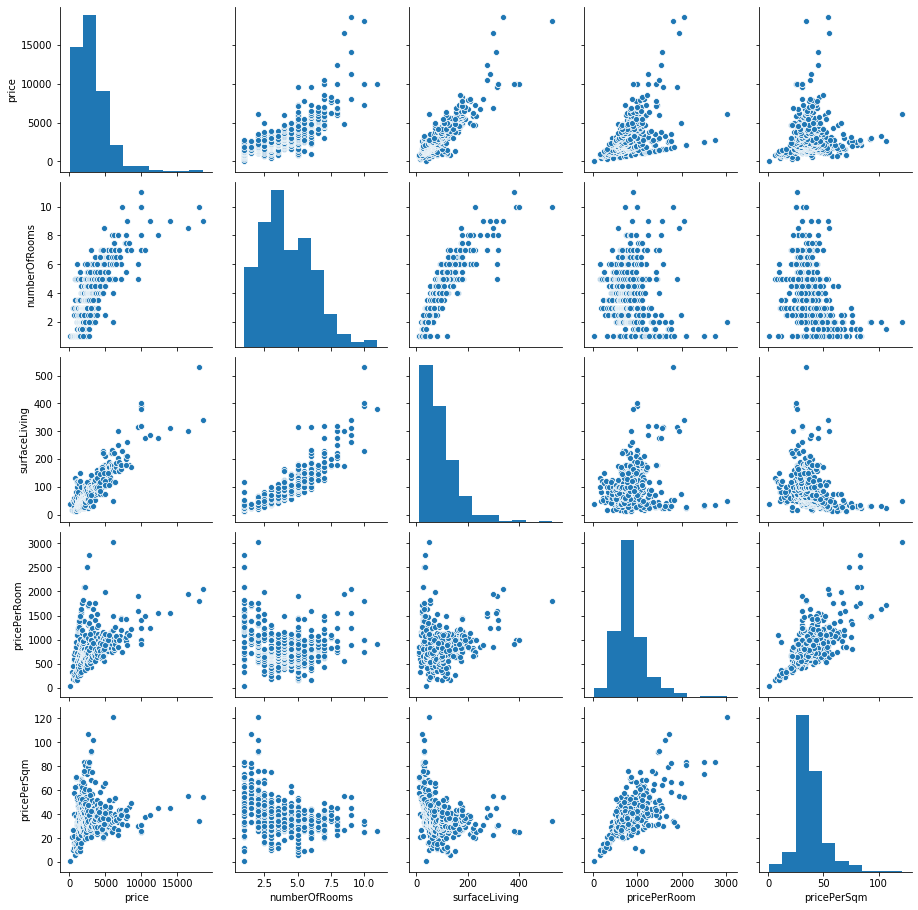

In [31]:
## we get a visual feedback of the correlations between features
sns.pairplot(df[reduce_features].loc[:,df.dtypes == 'float64'])

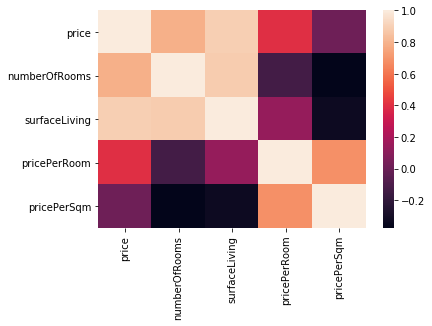

In [33]:
### we get a visual feedback of the correlations between features
corr = df[reduce_features].loc[:,df.dtypes == 'float64'].corr()
sns.heatmap(corr)

In [34]:
### we get a visual feedback of the correlations between features
corr

,price,numberOfRooms,surfaceLiving,pricePerRoom,pricePerSqm
price,1.000000,0.786579,0.894253,0.401301,0.016924
numberOfRooms,0.786579,1.000000,0.884011,-0.130619,-0.373808
surfaceLiving,0.894253,0.884011,1.000000,0.137353,-0.327297
pricePerRoom,0.401301,-0.130619,0.137353,1.000000,0.686045
pricePerSqm,0.016924,-0.373808,-0.327297,0.686045,1.000000


In [36]:
## we define the equation of a line for fitting
def poly1(x, c1,c2):
     y = c1 + c2*x
     return y


 C1 = 365.146098, C2 = 30.849626
Mean absolute error: 672.80
Residual sum of squares (MSE): 1215558.03
R2-score: 0.66


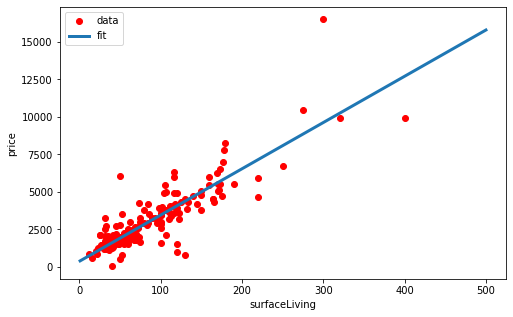

In [40]:
## fit with poly1
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

#split test-train
msk = np.random.rand(len(df)) < 0.7

train_x = df['surfaceLiving'][msk]
train_y = df['price'][msk]
test_x = df['surfaceLiving'][~msk]
test_y = df['price'][~msk]

popt, pcov = curve_fit(poly1, train_x, train_y)
#print the final parameters
print(" C1 = %f, C2 = %f" % (popt[0], popt[1]))

# CHECK ACCURACY ON TEST SAMPLE

y_hat = poly1(test_x, *popt)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y) )


## plot of fit and test data
x = np.linspace(1, 500, 351)
plt.figure(figsize=(8,5))
y = poly1(x, *popt)
plt.plot(test_x, test_y, 'ro', label='data')
plt.plot(x,y, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('price')
plt.xlabel('surfaceLiving')
plt.show()


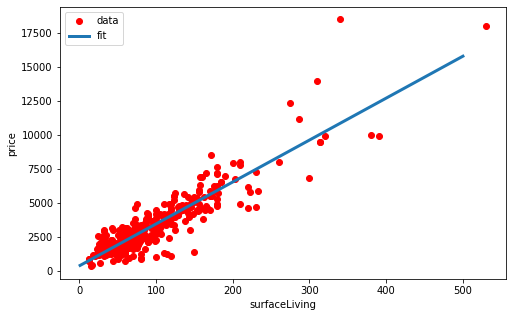

In [42]:
## plot of fit and train data
x = np.linspace(1, 500, 351)
plt.figure(figsize=(8,5))
y = poly1(x, *popt)
plt.plot(train_x, train_y, 'ro', label='data')
plt.plot(x,y, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('price')
plt.xlabel('surfaceLiving')
plt.show()

In [44]:
## for each property, we can calculate the deviation of the price from the expcted price, normalized by the price

df["price_dev"] = df.apply(lambda row: (row.price-poly1(row.surfaceLiving, *popt))/row.price, axis = 1) 
df.head()

,cityName,extraPrice,price,latitude,longitude,numberOfRooms,street,surfaceLiving,zip,pricePerRoom,pricePerSqm,price_dev
6065071,Genève,350.0,2550.0,46.19363,6.16698,4.0,Rue Le Corbusier 18,85.0,1208,637.500000,30.000000,-0.171515
6046525,Genève,200.0,4200.0,46.19646,6.16090,5.5,Route de Malagnou 40E,110.0,1208,763.636364,38.181818,0.105094
6063101,Genève,170.0,2810.0,46.20429,6.15891,4.0,Rue du 31-Décembre 16,60.0,1207,702.500000,46.833333,0.211344
6054808,Genève,250.0,4750.0,46.19523,6.15391,7.0,Rue Marignac,165.0,1206,678.571429,28.787879,-0.148491
6037279,Le Lignon,200.0,2700.0,46.20313,6.09613,6.0,Avenue du Lignon,107.0,1219,450.000000,25.233645,-0.357799


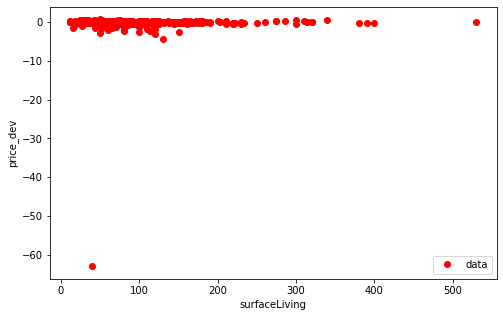

In [45]:
## searching for outliers
plt.figure(figsize=(8,5))
plt.plot(df["surfaceLiving"], df["price_dev"], 'ro', label='data')

plt.legend(loc='best')
plt.ylabel('price_dev')
plt.xlabel('surfaceLiving')
#plt.ylim(-2, 2)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


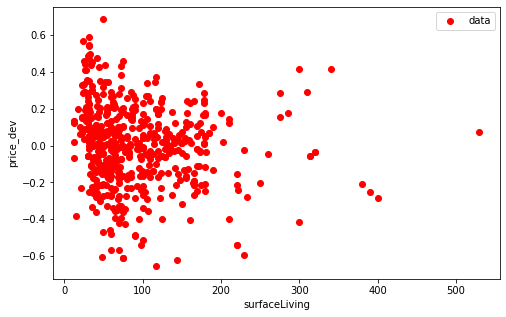

In [46]:
## we filter out outliers
df2 = df[df['price_dev']>-0.7][df['price_dev']<0.7]
plt.figure(figsize=(8,5))
plt.plot(df2["surfaceLiving"], df2["price_dev"], 'ro', label='data')

plt.legend(loc='best')
plt.ylabel('price_dev')
plt.xlabel('surfaceLiving')
#plt.ylim(-2, 2)
plt.show()

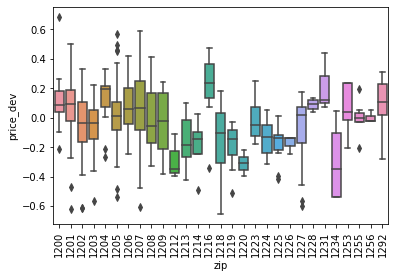

In [47]:
## exploratory boxplots
ax = sns.boxplot(x='zip', y='price_dev', data=df2)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

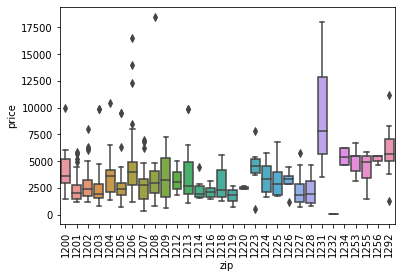

In [48]:
## exploratory boxplots
ax = sns.boxplot(x="zip", y="price", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax

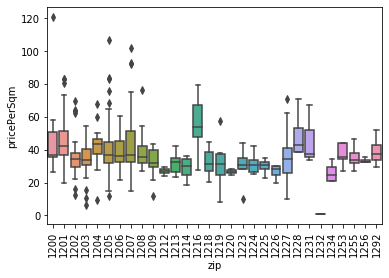

In [50]:
## exploratory boxplots
ax = sns.boxplot(x="zip", y="pricePerSqm", data=df[df.numberOfRooms < 20])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax

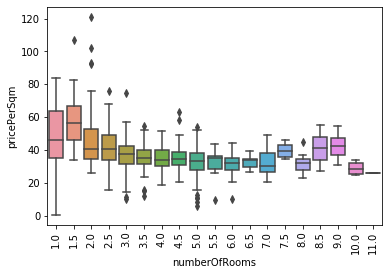

In [51]:
## exploratory boxplots
ax = sns.boxplot(x="numberOfRooms", y="pricePerSqm", data=df[df.numberOfRooms < 20])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax

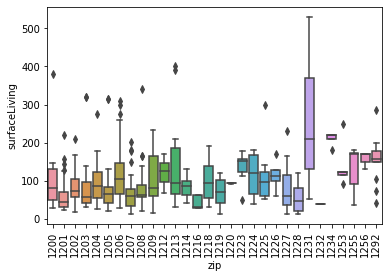

In [52]:
GenevaPOI.json## exploratory boxplots
ax = sns.boxplot(x="zip", y='surfaceLiving', data=df[df.numberOfRooms < 20])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax

In [54]:
#We finally save our database into a json file for later use.
df2.to_json(r'db_geneva_app_FA.json') 